# IBM Capstone Project - A Chinese restaurant in Rome

This notebook is the final assignment of the course "Applied data science Capstone" hosted on Coursera (https://www.coursera.org/learn/applied-data-science-capstone#syllabus).

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Borough selection](#Borough)
* [Neighborhood selection](#Neighborhood)
* [K-means clustering](#Kmeans)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening a **Chinese restaurant** in **Rome**, Italy.

Since there are lots of restaurants in Rome, we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no asian restaurants in the vicinity**. We would also prefer locations **as close to historic city center as possible** in order to be sure to have a good number of tourists.

The actual work will try to show the possible advantages of each area. At the end it will try to find the best location for a restaurant.

## Data <a name="data"></a>

Considering the previous problem, factors that will influence our decision are:
* the selection of good Boroughs (this part is very important because Rome territory is very large)
* number of other Asian restaurants in the neighborhood
* relation between the number of tourists and the area of interest
* the economic condition of the neighboorhod

Firstly, we import the needed libraries.

In [21]:
import requests                           # allow to send request to website
from bs4 import BeautifulSoup             # used to read data from a web page
import pandas as pd                       # to manipulate data
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium                             # map rendering library
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values
import numpy as np                        # to manipulate array and narray
from sklearn.cluster import KMeans        # import k-means from clustering stage
import matplotlib.cm as cm                # Matplotlib and associated plotting modules
import matplotlib.colors as colors        # use colors in plot
import os                                 # find files on the operative system
import json                               # menage json files
import geocoder                           # get coordinates of a given city
# use the inline backend to generate the plots within the browser
%matplotlib inline 
# library used to create plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values

In [22]:
# we define a function to compute distances between 2 points, knowing geographical coordinates
def distance2points(lat_ref,lon_ref,lat,lon):
    f= 1/298.257   # Earth Flattening radius
    radius = 6371  # Earth Mean Equatorial Radius [km]
    conv= math.pi/180
    # Distance in km based on Haversine formula
    deltaLat=lat_ref-lat 
    deltaLon=lon_ref-lon
    a=math.sin((deltaLat*conv)/2)**2 + math.cos(lat*conv)*math.cos(lat*conv) * math.sin(deltaLon*conv/2)**2;
    c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    d=radius*c # Haversine distance
    return d

# Borough selection <a name="Borough"></a>

The first step will be to identify Rome's Boroughs and find those of greatest interest. Foursquare API allows to get the most common venues of a given Borough. Those for which data are insufficient or those that are less attractive are discarded. 
I've prepared a dataset offline using information from wikipedia and google maps to obtain coordinates. The dataset display Rome's boroughs, the population for each borough and their geographical coordinates and their territorial extension.

In [23]:
df_Rome = pd.read_excel('datasetRome.xlsx') 
df_Rome.head()

,Borough,Population,Latitude,Longitude,Area [km^2]
0,I Centro Storico,186802,41.89306,12.48278,19.91
1,II Parioli/Nomentano,167736,41.92996,12.51889,13.67
2,III Monte Sacro,204514,41.93608,12.53512,97.82
3,IV Tiburtina,177084,41.93349,12.59875,49.15
4,V Prenestino/Centocelle,246471,41.89066,12.54849,26.98


We compute distances of each borough from the city center

In [24]:
distances=[]
lat_center=df_Rome['Latitude'][0]
lon_center=df_Rome['Longitude'][0]
for lat,lon in zip(df_Rome['Latitude'],df_Rome['Longitude']):
    distances.append(distance2points(lat_center,lon_center,lat,lon))
df_Rome['Dist_to_Center']=distances
df_Rome.head()

,Borough,Population,Latitude,Longitude,Area [km^2],Dist_to_Center
0,I Centro Storico,186802,41.89306,12.48278,19.91,0.000000
1,II Parioli/Nomentano,167736,41.92996,12.51889,13.67,5.075303
2,III Monte Sacro,204514,41.93608,12.53512,97.82,6.451868
3,IV Tiburtina,177084,41.93349,12.59875,49.15,10.594218
4,V Prenestino/Centocelle,246471,41.89066,12.54849,26.98,5.445739


We will consider only boroughs within a range of 6 km from the city center. We display Rome's boroughs on a maps created with folium. In order to get a map centered on the city of Rome, we have to obtain Rome coordinates. We will use the geolocator library.

In [25]:
address = 'Rome, RM'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitudeRome = location.latitude
longitudeRome = location.longitude
print('The geograpical coordinate of Rome City are {}, {}.'.format(latitudeRome, longitudeRome))

The geograpical coordinate of Rome City are 41.8933203, 12.4829321.


In [26]:
# function to plot data on a map
def urban_plot(dataframe,color):
    # add markers to map
    for lat, lng, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Borough']):
        label = '{}'.format(borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=7,
            popup=label,
            color=color,
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_Rome) 

In [27]:
# create map of Rome using latitude and longitude values
dist_from_center=6 # we define the distance from the historic center 
map_Rome = folium.Map(location=[latitudeRome, longitudeRome], zoom_start=10)
df_Rome1=df_Rome[df_Rome['Dist_to_Center']<=dist_from_center]
df_Rome2=df_Rome[df_Rome['Dist_to_Center']>dist_from_center]
urban_plot(df_Rome1,'blue')
urban_plot(df_Rome2,'red')
map_Rome

We drop dataframes rows which correspond to Rome's borough that are more than 6 kilometers away from the center

In [28]:
df_Rome=df_Rome1
df_Rome.head()

,Borough,Population,Latitude,Longitude,Area [km^2],Dist_to_Center
0,I Centro Storico,186802,41.89306,12.48278,19.91,0.000000
1,II Parioli/Nomentano,167736,41.92996,12.51889,13.67,5.075303
4,V Prenestino/Centocelle,246471,41.89066,12.54849,26.98,5.445739
6,VII Appio-Latino/Tuscolana/Cinecittà,307607,41.88170,12.52280,46.75,3.545783
7,VIII Appia Antica,131082,41.84123,12.48429,47.29,5.764590


Now, we retreive the number of venues for each borough, in particular we will look for asian restaurants. We have to define foursquare credentials and then to do a request.

In [29]:
# we define the credentials to retreive data from foursquare
CLIENT_ID = 'RIRUAJ0XVCM3JGKHZONTX11KWFVFSIDCZF5F0VUJYEN2G0YX' # your Foursquare ID
CLIENT_SECRET = 'JV2VFFJFRJG2XRZINIWOXIS4NNUIZ1LJGITF4I1XYAAGBA5T' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

We define other parameters for our research

In [30]:
LIMIT = 300 # limit of number of venues returned by Foursquare API
food_category = '4bf58dd8d48988d142941735' # This ID corresponds to Asian restaurant
# In the following we have IDs corresponding to specific types in dataset
# Chinese restaurant 4bf58dd8d48988d145941735
# Korean restaurant 4bf58dd8d48988d113941735
# Asian restaurant 4bf58dd8d48988d142941735
# Restaurants 4d4b7105d754a06374d81259
# African restaurants  4bf58dd8d48988d1c8941735
# Arts & Entertainment 4d4b7104d754a06370d81259
#### Museums 4bf58dd8d48988d181941735
#### Historic sites 4deefb944765f83613cdba6e
radius = 1500 # define radius
category=food_category


In [31]:
# This function allow to get venues for each Borough within a given radius (defined above).
def getNearbyVenues(names, latitudes, longitudes, category, radius=500):
    # This function call foursquare api interface in order to get venues for specified latitude, longitude, 
    # category and within a given radius (default value is 500)
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format( 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We look for the most interesting Boroughs seeing the distribution of the points of interest. Rome is a city that bases its economy on tourism, therefore it is more desirable to look for areas close to historic sites, theaters and squares. At the same time, we must keep in mind that competition in these areas will be greater.

In [32]:
# we get art and entertainment venues for each borough
df_rome_tourism_venues = getNearbyVenues(names=df_Rome['Borough'],
                                   latitudes=df_Rome['Latitude'],
                                   longitudes=df_Rome['Longitude'],
                                   category='4d4b7104d754a06370d81259',
                                   radius=radius)
# we get museum venues (it is a sub-groups of art and entertainment) for each borough
df_rome_museum_venues = getNearbyVenues(names=df_Rome['Borough'],
                                   latitudes=df_Rome['Latitude'],
                                   longitudes=df_Rome['Longitude'],
                                   category='4bf58dd8d48988d181941735',
                                   radius=radius)
# we get historic sites (it is a sub-groups of art and entertainment) for each borough
df_rome_historic_venues = getNearbyVenues(names=df_Rome['Borough'],
                                   latitudes=df_Rome['Latitude'],
                                   longitudes=df_Rome['Longitude'],
                                   category='4deefb944765f83613cdba6e',
                                   radius=radius)


In [33]:
# we create a new dataframe with the number of point of interests
rome_tourism_venues=df_rome_tourism_venues.Borough.value_counts()
rome_tourism_venues=rome_tourism_venues.to_frame()
rome_tourism_venues.reset_index(drop=False, inplace=True)
rome_tourism_venues.columns =['Borough','Arts & Entertainment']
rome_tourism_venues.set_index('Borough', inplace=True)

rome_museum_venues=df_rome_museum_venues.Borough.value_counts()
rome_museum_venues=rome_museum_venues.to_frame()
rome_museum_venues.reset_index(drop=False, inplace=True)
rome_museum_venues.columns =['Borough','Museums']
rome_museum_venues.set_index('Borough', inplace=True)

rome_historic_venues=df_rome_historic_venues.Borough.value_counts()
rome_historic_venues=rome_historic_venues.to_frame()
rome_historic_venues.reset_index(drop=False, inplace=True)
rome_historic_venues.columns =['Borough','Historic sites']
rome_historic_venues.set_index('Borough', inplace=True)



In [34]:
# we get asian restaurants for each borough
df_rome_venues = getNearbyVenues(names=df_Rome['Borough'],
                                   latitudes=df_Rome['Latitude'],
                                   longitudes=df_Rome['Longitude'],
                                   category='4bf58dd8d48988d142941735',
                                   radius=radius)

# we create a new dataframe with the number of asian restaurant 
venues_for_borough=df_rome_venues.Borough.value_counts()
venues_for_borough=venues_for_borough.to_frame()
venues_for_borough.reset_index(drop=False, inplace=True)
venues_for_borough.columns =['Borough','Asian Restaurant']
venues_for_borough.set_index('Borough', inplace=True)


# we get chinese restaurants
df_rome_chinese = getNearbyVenues(names=df_Rome['Borough'],
                                   latitudes=df_Rome['Latitude'],
                                   longitudes=df_Rome['Longitude'],
                                   category='4bf58dd8d48988d145941735',
                                   radius=radius)


# we get the number of venues for each borough and we create a new dataframe 
rome_chinese_res=df_rome_chinese.Borough.value_counts()
rome_chinese_res=rome_chinese_res.to_frame()
rome_chinese_res.reset_index(drop=False, inplace=True)
rome_chinese_res.columns =['Borough','Chinese Restaurant']
rome_chinese_res.set_index('Borough', inplace=True)

In [35]:
# we merge dataframe containing data about Asian restaurants and Chinese restaurants, we add their density and the point of interest
names = rome_chinese_res.index
df_Rome.set_index('Borough', inplace=True)
df = pd.DataFrame({'Borough': names, "Asian Restaurant": venues_for_borough.loc[names].values[:,0], "Chinese Restaurant": rome_chinese_res.loc[names].values[:,0], \
                  "Asian Restaurant density": venues_for_borough.loc[names].values[:,0]/df_Rome.loc[names].values[:,3], \
                  "Chinese Restaurant density": rome_chinese_res.loc[names].values[:,0]/df_Rome.loc[names].values[:,3], \
                  "Arts & Entertainment": rome_tourism_venues.loc[names].values[:,0],\
                  "Historic sites": rome_historic_venues.loc[names].values[:,0],\
                  })
df.set_index('Borough', inplace=True)
df.head()

C:\Users\tecno\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,Asian Restaurant,Chinese Restaurant,Asian Restaurant density,Chinese Restaurant density,Arts & Entertainment,Historic sites
Borough,,,,,,
I Centro Storico,47,19,2.360623,0.954294,91,100.0
VII Appio-Latino/Tuscolana/Cinecittà,24,8,0.513369,0.171123,19,2.0
XIII Aurelia,9,6,0.131062,0.087374,4,NaN
II Parioli/Nomentano,12,5,0.877835,0.365764,8,4.0
VIII Appia Antica,7,5,0.148023,0.105731,11,1.0


We replace nan value in the dataframe with zeros

In [36]:
df=df.fillna(0)
df.head()

,Asian Restaurant,Chinese Restaurant,Asian Restaurant density,Chinese Restaurant density,Arts & Entertainment,Historic sites
Borough,,,,,,
I Centro Storico,47,19,2.360623,0.954294,91,100.0
VII Appio-Latino/Tuscolana/Cinecittà,24,8,0.513369,0.171123,19,2.0
XIII Aurelia,9,6,0.131062,0.087374,4,0.0
II Parioli/Nomentano,12,5,0.877835,0.365764,8,4.0
VIII Appia Antica,7,5,0.148023,0.105731,11,1.0


We create a bar chart displaying the number of venues of catageries "Arts and Entertainment" and "Historic sites" for each borough.

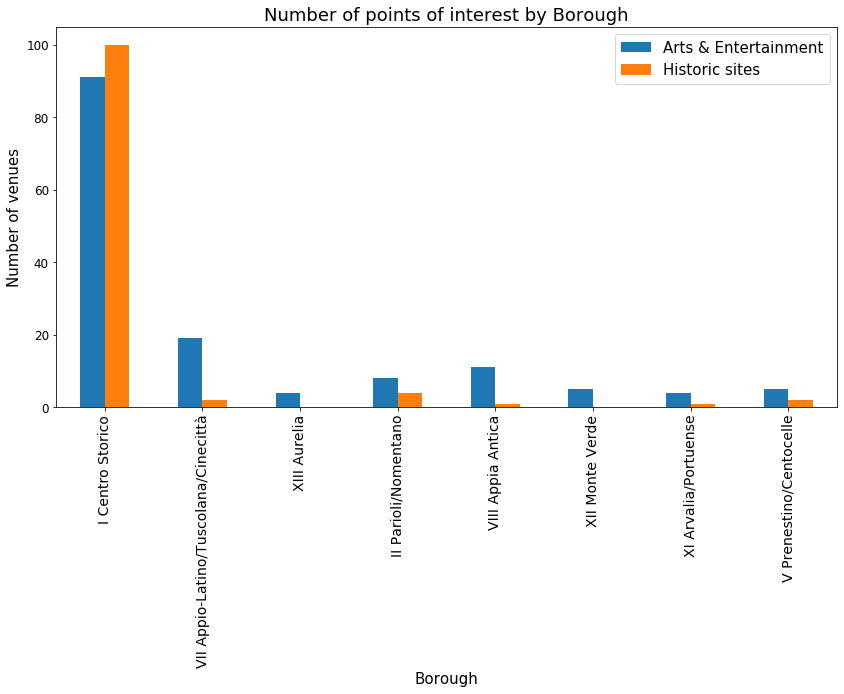

In [37]:
# we create two bar chart plots 
df1 = df[['Asian Restaurant','Chinese Restaurant']]
df2 = df[['Asian Restaurant density','Chinese Restaurant density']]

df0 = df[['Arts & Entertainment','Historic sites']]
df0.plot(kind='bar',figsize=(14,7),legend=True, fontsize=12)
plt.ylabel('Number of venues', size=15)
plt.xlabel('Borough', size=15)
plt.title("Number of points of interest by Borough",fontsize=18)
borough = df1.index
x = range(len(borough))
plt.xticks(x, borough, fontsize=14 ,rotation='vertical')
plt.legend(fontsize=15)

From the previous graph we can see how points of interests such as art galleries, theaters and museums are mainly concentrated in the Borough "I Centro Storico", that is, the center and heart of city life. Other particularly interesting Boroughs are: "VII Appio-Latino/Tuscolana/Cinecittà", "VIII Appia Antica", "II Parioli/ Nomentano" and "V Prenestino/Centocelle". We can now look for the number of asian restaurants within each Borough. Particularly, we will look for chinese restaurants.

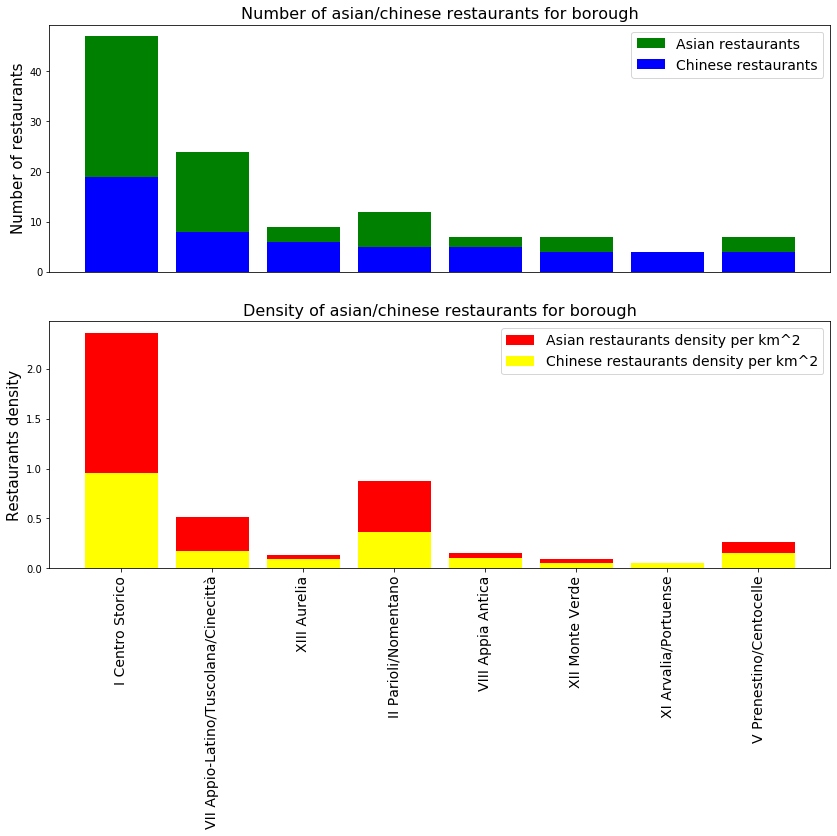

In [38]:
#The below code will create two plots
# Creates two subplots and unpacks the output array immediately
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)

borough = df1.index
x = range(len(borough))

#This will create the bar graph for poulation
nb_rest = df1.values
plt.bar(x,nb_rest[:,0], color='green', label='Asian restaurants')
plt.bar(x,nb_rest[:,1], color='blue', label='Chinese restaurants')
plt.ylabel('Number of restaurants',size=15)
plt.title('Number of asian/chinese restaurants for borough',fontsize=16)
plt.xticks([],[])
plt.legend(fontsize=14)

#The below code will create the second plot.
plt.subplot(2,1,2)
dens_rest=df2.values
plt.bar(x, dens_rest[:,0], color='red', label='Asian restaurants density per km^2')
plt.bar(x, dens_rest[:,1], color='yellow', label='Chinese restaurants density per km^2')
plt.ylabel('Restaurants density',size=15)
plt.title('Density of asian/chinese restaurants for borough',fontsize=16)
plt.xticks([],[])
plt.legend(fontsize=14)

plt.xticks(x, borough, fontsize=14 ,rotation='vertical')
plt.show()

As it is possible to observe from the previous graphs, although the historic center is the point of greatest 
interest for tourists and citizens, that area has a significantly higher density of Asian restaurants than for other Boroughs (over 2 Asian restaurants per square kilometer one of which chinese). 
Therefore, in the following analysis, we will consider also: "VII Appio-Latino/Tuscolana/Cinecittà", "VIII Appia Antica", "II Parioli/ Nomentano" and "V Prenestino/Centocelle".
We will clean our dataframe with data about asian restaurants considering only the selected Boroughs.

In [39]:
df_asian_restaurants = df_rome_venues[(df_rome_venues['Borough']=='I Centro Storico') | \
                                   (df_rome_venues['Borough']=='VIII Appia Antica')| \
                                   (df_rome_venues['Borough']=='II Parioli/Nomentano')| \
                                   (df_rome_venues['Borough']=='VII Appio-Latino/Tuscolana/Cinecittà')| \
                                   (df_rome_venues['Borough']=='V Prenestino/Centocelle')]
df_asian_restaurants.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,I Centro Storico,41.89306,12.48278,Green Tea,41.897620,12.479270,Asian Restaurant
1,I Centro Storico,41.89306,12.48278,Kuriya,41.892250,12.474745,Asian Restaurant
2,I Centro Storico,41.89306,12.48278,Tin House,41.894866,12.492497,Chinese Restaurant
3,I Centro Storico,41.89306,12.48278,Mr Chow Jr,41.899065,12.492453,Asian Restaurant
4,I Centro Storico,41.89306,12.48278,Zhong Yi,41.899456,12.482188,Chinese Restaurant


In [40]:
df_Rome.reset_index(drop=False, inplace=True)
df_Rome = df_Rome[(df_Rome['Borough']=='I Centro Storico') | \
                                   (df_Rome['Borough']=='VIII Appia Antica')| \
                                   (df_Rome['Borough']=='II Parioli/Nomentano')| \
                                   (df_Rome['Borough']=='VII Appio-Latino/Tuscolana/Cinecittà')| \
                                   (df_Rome['Borough']=='V Prenestino/Centocelle')]
df_Rome.head()

,Borough,Population,Latitude,Longitude,Area [km^2],Dist_to_Center
0,I Centro Storico,186802,41.89306,12.48278,19.91,0.000000
1,II Parioli/Nomentano,167736,41.92996,12.51889,13.67,5.075303
2,V Prenestino/Centocelle,246471,41.89066,12.54849,26.98,5.445739
3,VII Appio-Latino/Tuscolana/Cinecittà,307607,41.88170,12.52280,46.75,3.545783
4,VIII Appia Antica,131082,41.84123,12.48429,47.29,5.764590


# Neighborhood selection <a name="neighborhood"></a>

Currently there is not a single internet source that reports the neighborhoods for each of the selected Boroughs, therefore, I have prepared a dataset with the neighborhoods for each of the identified areas and their respective coordinates searching offline.
We read the dataset, we compute the distance of each neighborhood with respect to the city center and we search through API Foursquare for the number of venues (asian restaurants) for each neighborhood.

In [41]:
df_Rome_neigh = pd.read_excel('datasetNeighRome.xlsx') 
df_Rome_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,I Centro Storico,1A Centro Storico,41.899,12.4766
1,I Centro Storico,1B Trastevere,41.886,12.4590
2,I Centro Storico,1C Aventino,41.880,12.4850
3,I Centro Storico,1D Testaccio,41.893,12.4830
4,I Centro Storico,1E Esquilino,41.900,12.5000


In [42]:
distances=[]
for lat,lon in zip(df_Rome_neigh['Latitude'],df_Rome_neigh['Longitude']):
    distances.append(distance2points(lat_center,lon_center,lat,lon))
df_Rome_neigh['Dist_to_Center']=distances
df_Rome_neigh.head()

,Borough,Neighborhood,Latitude,Longitude,Dist_to_Center
0,I Centro Storico,1A Centro Storico,41.899,12.4766,0.835390
1,I Centro Storico,1B Trastevere,41.886,12.4590,2.119310
2,I Centro Storico,1C Aventino,41.880,12.4850,1.463790
3,I Centro Storico,1D Testaccio,41.893,12.4830,0.019394
4,I Centro Storico,1E Esquilino,41.900,12.5000,1.620703


We redefine the names in the function getNearbyVenues.

In [43]:
# This function allow to get venues for each Borough within a given radius (defined above).
def getNearbyVenues(names, latitudes, longitudes, category, radius=500):
    # This function call foursquare api interface in order to get venues for specified latitude, longitude, 
    # category and within a given radius (default value is 500)
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format( 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
# we get asian restaurants for each neighborhood
df_rome_neigh_venues = getNearbyVenues(names=df_Rome_neigh['Neighborhood'],
                                       latitudes=df_Rome_neigh['Latitude'],
                                       longitudes=df_Rome_neigh['Longitude'],
                                       category='4bf58dd8d48988d142941735',
                                       radius=500)
df_rome_neigh_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1A Centro Storico,41.899,12.4766,Green Tea,41.897620,12.479270,Asian Restaurant
1,1A Centro Storico,41.899,12.4766,Zhong Yi,41.899456,12.482188,Chinese Restaurant
2,1A Centro Storico,41.899,12.4766,Kisaki Ramen & Sushi,41.899850,12.477845,Ramen Restaurant
3,1A Centro Storico,41.899,12.4766,Daruma Sushi Restaurant - Parlamento,41.902378,12.477739,Sushi Restaurant
4,1A Centro Storico,41.899,12.4766,Tora Sushi & Asian Cuisine,41.899463,12.473935,Sushi Restaurant


In [45]:
df_rome_neigh_venues.shape

(125, 7)

## Kmeans clustering <a name="Kmeans"></a>

In [46]:
# one hot encoding
rome_venueshot = pd.get_dummies(df_rome_neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rome_venueshot['Neighborhood'] = df_rome_neigh_venues['Neighborhood'] 

# move Borough column to the first column
fixed_columns = [rome_venueshot.columns[-1]] + list(rome_venueshot.columns[:-1])
rome_venueshot = rome_venueshot[fixed_columns]

rome_venueshot.head()

,Neighborhood,Asian Restaurant,Burger Joint,Café,Chinese Restaurant,Filipino Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Noodle House,Pub,Ramen Restaurant,Restaurant,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant
0,1A Centro Storico,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1A Centro Storico,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1A Centro Storico,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1A Centro Storico,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1A Centro Storico,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [47]:
rome_venueshot.shape

(125, 16)

In [48]:
rome_grouped = rome_venueshot.groupby('Neighborhood').mean().reset_index()
rome_grouped.head()

,Neighborhood,Asian Restaurant,Burger Joint,Café,Chinese Restaurant,Filipino Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Noodle House,Pub,Ramen Restaurant,Restaurant,Sushi Restaurant,Szechuan Restaurant,Thai Restaurant
0,10A Don Bosco,0.000000,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0
1,10I Barcaccia,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.0
2,11A Ostiense,0.333333,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0
3,11B Valco San Paolo,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,11D Navigatori,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [49]:
num_top_venues = 3

for hood in rome_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = rome_grouped[rome_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10A Don Bosco----
                 venue  freq
0   Chinese Restaurant  0.33
1  Japanese Restaurant  0.33
2     Sushi Restaurant  0.33


----10I Barcaccia----
              venue  freq
0               Pub   1.0
1  Asian Restaurant   0.0
2      Burger Joint   0.0


----11A Ostiense----
                 venue  freq
0     Asian Restaurant  0.33
1  Japanese Restaurant  0.33
2     Ramen Restaurant  0.33


----11B Valco San Paolo----
              venue  freq
0  Asian Restaurant   1.0
1      Burger Joint   0.0
2              Café   0.0


----11D Navigatori----
                 venue  freq
0  Japanese Restaurant   1.0
1     Asian Restaurant   0.0
2         Burger Joint   0.0


----11E Tor Marancia----
                venue  freq
0  Chinese Restaurant   1.0
1    Asian Restaurant   0.0
2        Burger Joint   0.0


----11F Tre Fontane----
                venue  freq
0  Chinese Restaurant   0.5
1    Sushi Restaurant   0.5
2    Asian Restaurant   0.0


----17A Prati----
                venue  

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Neighborhood'] = rome_grouped['Neighborhood']

for ind in np.arange(rome_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rome_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10A Don Bosco,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
1,10I Barcaccia,Pub,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Noodle House,Korean Restaurant,Japanese Restaurant,Italian Restaurant
2,11A Ostiense,Ramen Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Pub,Noodle House,Korean Restaurant
3,11B Valco San Paolo,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
4,11D Navigatori,Japanese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Italian Restaurant


### Choose best number of cluster for the k means algorithm

K-Means is an unsupervised machine learning algorithm thatclusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the "inertia". 
In order to choose the best number of clusters we will use the "Elbow method". It a technique  is a very popular technique that runs the k-means clustering algorithm for a range of clusters k. For each value, we compute the inertia also called "distortions".
When the distortions are plotted and the plot looks like an arm then the “elbow” (the point of inflection on the curve) is the best value of k.

In [52]:
distortions = []
K = range(1,12)
rome_grouped_clustering = rome_grouped.drop('Neighborhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rome_grouped_clustering)
    distortions.append(kmeans.inertia_)

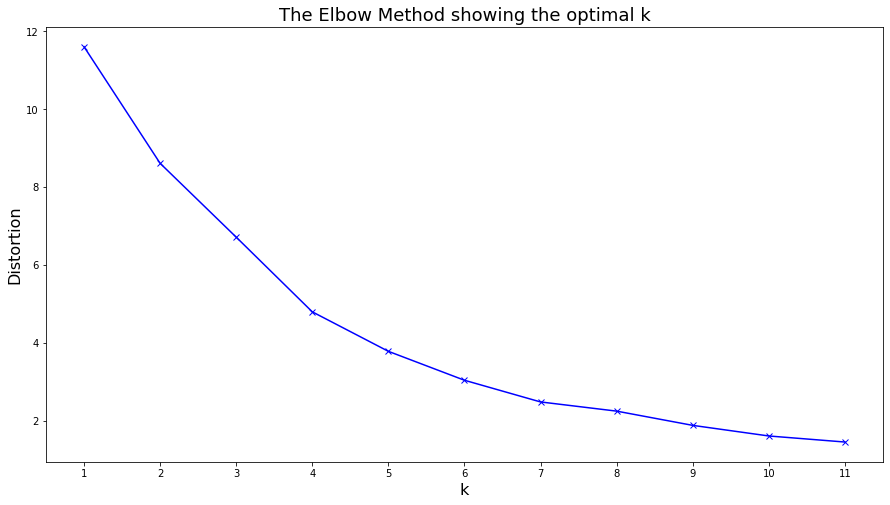

In [53]:
plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-')
plt.xticks(K)
plt.xlabel('k', fontsize=16)
plt.ylabel('Distortion', fontsize=16)
plt.title('The Elbow Method showing the optimal k', fontsize=18)
plt.show()

From previous graph we can see that the optimal value is obtained for k=7

In [54]:
# set the optimal number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(rome_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 0, 3, 6, 1, 2, 2, 2, 2])

In [55]:
# add clustering labels
borough_venues_sorted2=borough_venues_sorted
borough_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

rome_merged = df_Rome_neigh

# merge data to add latitude/longitude for each neighborhood
rome_merged = rome_merged.join(borough_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

rome_merged.head() # check the last columns!


,Borough,Neighborhood,Latitude,Longitude,Dist_to_Center,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I Centro Storico,1A Centro Storico,41.899,12.4766,0.835390,2.0,Sushi Restaurant,Chinese Restaurant,Ramen Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Pub,Noodle House,Korean Restaurant
1,I Centro Storico,1B Trastevere,41.886,12.4590,2.119310,1.0,Chinese Restaurant,Sushi Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
2,I Centro Storico,1C Aventino,41.880,12.4850,1.463790,2.0,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
3,I Centro Storico,1D Testaccio,41.893,12.4830,0.019394,2.0,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
4,I Centro Storico,1E Esquilino,41.900,12.5000,1.620703,0.0,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Japanese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub


If we observe the previus dataframe we can notice that for some neighborhood we didn't find some asian resturants, therefore they have the value "NaN" as label. We create a new label for this group, then we will have one class more in our K means clustering algorithm.

In [56]:
rome_merged['Cluster Labels'] = rome_merged['Cluster Labels'].fillna(kclusters)
rome_merged

,Borough,Neighborhood,Latitude,Longitude,Dist_to_Center,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,I Centro Storico,1A Centro Storico,41.899,12.4766,0.835390,2.0,Sushi Restaurant,Chinese Restaurant,Ramen Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Pub,Noodle House,Korean Restaurant
1,I Centro Storico,1B Trastevere,41.886,12.4590,2.119310,1.0,Chinese Restaurant,Sushi Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
2,I Centro Storico,1C Aventino,41.880,12.4850,1.463790,2.0,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
3,I Centro Storico,1D Testaccio,41.893,12.4830,0.019394,2.0,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
4,I Centro Storico,1E Esquilino,41.900,12.5000,1.620703,0.0,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Japanese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub
5,I Centro Storico,1F XX Settembre,41.905,12.4950,1.668956,0.0,Japanese Restaurant,Chinese Restaurant,Szechuan Restaurant,Filipino Restaurant,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub
6,I Centro Storico,1G Celio,41.881,12.4940,1.631299,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,I Centro Storico,1X Zona archeologica,41.890,12.4870,0.487644,5.0,Noodle House,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Korean Restaurant
8,I Centro Storico,17A Prati,41.908,12.4660,2.165172,2.0,Sushi Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House
9,I Centro Storico,17B Della Vittoria,41.930,12.4570,4.628181,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# create map
map_clusters = folium.Map(location=[latitudeRome, longitudeRome], zoom_start=11)
# we have added a new cluster
kclusters=kclusters+1
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#rainbow=['green','red','blue','black']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rome_merged['Latitude'], rome_merged['Longitude'], rome_merged.index, rome_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clusters analysis 

By using the Kmeans algorithm we have identified 7 clusters. In particular, we have noticed that some neighborhoods did not fall into any of the clusters as they did not have Asian restaurants within the specified distance. We have therefore created a new class with all the neighborhoods that do not contain Asian and in particular Chinese restaurants. We will be particularly interested in this class and we will consider only the neighborhoods closest to the historic center of the city (notoriously, as shown in the previous analyses, this is the most attractive area of the city and principal destination of tourists).
However, before, we will display the 8 clusters.

In [1086]:
rome_merged.loc[rome_merged['Cluster Labels'] == 0, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,1E Esquilino,0.0,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Japanese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub
5,1F XX Settembre,0.0,Japanese Restaurant,Chinese Restaurant,Szechuan Restaurant,Filipino Restaurant,Asian Restaurant,Thai Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub
12,2B Parioli,0.0,Restaurant,Café,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
24,6C Quadraro,0.0,Asian Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House
37,9D Appio,0.0,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
38,9E Latino,0.0,Thai Restaurant,Chinese Restaurant,Asian Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
50,11A Ostiense,0.0,Ramen Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Pub,Noodle House,Korean Restaurant


In [1087]:
rome_merged.loc[rome_merged['Cluster Labels'] == 1, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,1B Trastevere,1.0,Chinese Restaurant,Sushi Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
22,6A Torpignattara,1.0,Chinese Restaurant,Noodle House,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Korean Restaurant,Japanese Restaurant
26,7A Centocelle,1.0,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
33,7H Omo,1.0,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
35,9B Tuscolano Sud,1.0,Chinese Restaurant,Sushi Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
36,9C Tor Fiscale,1.0,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
54,11E Tor Marancia,1.0,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant


In [1088]:
rome_merged.loc[rome_merged['Cluster Labels'] == 2, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1A Centro Storico,2.0,Sushi Restaurant,Chinese Restaurant,Ramen Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Pub,Noodle House,Korean Restaurant
2,1C Aventino,2.0,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
3,1D Testaccio,2.0,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
8,17A Prati,2.0,Sushi Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House
10,17C Eroi,2.0,Sushi Restaurant,Japanese Restaurant,Filipino Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
14,2D Salario,2.0,Sushi Restaurant,Korean Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Japanese Restaurant,Italian Restaurant
15,2E Trieste,2.0,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
19,3B San Lorenzo,2.0,Sushi Restaurant,Japanese Restaurant,Burger Joint,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
39,10A Don Bosco,2.0,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant
55,11F Tre Fontane,2.0,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant


In [1089]:
rome_merged.loc[rome_merged['Cluster Labels'] == 3, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,9A Tuscolano Nord,3.0,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant
51,11B Valco San Paolo,3.0,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Japanese Restaurant


In [1090]:
rome_merged.loc[rome_merged['Cluster Labels'] == 4, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,10I Barcaccia,4.0,Pub,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Noodle House,Korean Restaurant,Japanese Restaurant,Italian Restaurant


In [1091]:
rome_merged.loc[rome_merged['Cluster Labels'] == 5, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,1X Zona archeologica,5.0,Noodle House,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Korean Restaurant
25,6D Gordiani,5.0,Noodle House,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Korean Restaurant,Japanese Restaurant


In [1092]:
rome_merged.loc[rome_merged['Cluster Labels'] == 6, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,2C Flaminio,6.0,Japanese Restaurant,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House
18,3A Nomentano,6.0,Japanese Restaurant,Noodle House,Chinese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Korean Restaurant
20,3X Università,6.0,Japanese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Italian Restaurant
53,11D Navigatori,6.0,Japanese Restaurant,Thai Restaurant,Szechuan Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Pub,Noodle House,Korean Restaurant,Italian Restaurant


In [1101]:
rome_merged.loc[rome_merged['Cluster Labels'] == 7, rome_merged.columns[[1] + list(range(5, rome_merged.shape[1]))]].fillna('-')


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,1G Celio,7.0,-,-,-,-,-,-,-,-,-,-
9,17B Della Vittoria,7.0,-,-,-,-,-,-,-,-,-,-
11,2A Villaggio Olimpico,7.0,-,-,-,-,-,-,-,-,-,-
16,2X Villa Borghese,7.0,-,-,-,-,-,-,-,-,-,-
17,2Y Villa Ada,7.0,-,-,-,-,-,-,-,-,-,-
21,3Y Verano,7.0,-,-,-,-,-,-,-,-,-,-
23,6B Casilino,7.0,-,-,-,-,-,-,-,-,-,-
27,7B Alessandrina,7.0,-,-,-,-,-,-,-,-,-,-
28,7C Tor Sapienza,7.0,-,-,-,-,-,-,-,-,-,-
29,7D La Rustica,7.0,-,-,-,-,-,-,-,-,-,-


In this analysis we have indentified the following clusters:
labels:

0 --> Asian mixed restaurants 

1 --> Chinese restaurants

2 --> Sushi restaurants

3 --> Asian restaurants

4 --> Thai restaurants

5 --> Asian Pub

6 --> Noodle restaurants

7 --> No asian restaurants

We focus on neighborhoods with label 7. These neighborhoods could be particularly interesting to create our business. We look for the distance of each neighborhood from the historic center. Then, we will drop neighborhood too far from the center.

In [1118]:
selected_cluster = rome_merged[rome_merged['Cluster Labels']==7]
selected_cluster = selected_cluster[selected_cluster.columns[0:5]]
selected_cluster.head()

,Borough,Neighborhood,Latitude,Longitude,Dist_to_Center
6,I Centro Storico,1G Celio,41.881,12.494,1.631299
9,I Centro Storico,17B Della Vittoria,41.930,12.457,4.628181
11,II Parioli/Nomentano,2A Villaggio Olimpico,41.934,12.475,4.597585
16,II Parioli/Nomentano,2X Villa Borghese,41.913,12.485,2.224824
17,II Parioli/Nomentano,2Y Villa Ada,41.932,12.501,4.584751


We focus on neighborhood that are no more than 2 km away from the historic center.

In [1119]:
selected_cluster = selected_cluster[selected_cluster['Dist_to_Center']<2]
selected_cluster.head()

,Borough,Neighborhood,Latitude,Longitude,Dist_to_Center
6,I Centro Storico,1G Celio,41.881,12.494,1.631299


We have obtained only one neighborhood that respects the constraints imposed. Checking further with google maps it is possible to see how this area doesen't offer any asian, or better, chinese restaurants. Furthermore, reading information on internet, It is immediately evident that the selected neighborhood is very active and rich in religious architecture. In particular, it is located about 700 meters from the Colosseum, one of the main tourist destinations in Rome.

## Results and Discussion <a name="results"></a>

Our analysis has allowed us to see how decisions can be made in the presence of numerous variables and factors. In particular, it has been observed that thanks to data science techniques it has been possible to identify an optimal position for a Chinese restaurant in a city as vast as that of Rome. In addition, unsupervised machine learning techniques were used and have proven very useful in managing a large number of data. The following analysis allowed to identify an optimal area for stakeholders:ì. Indeed the selected neighborhood is close to the historic city center and far from the competition of restaurant of the same type.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Rome areas close to center with a low number of asian restaurants (in particular chinese restaurant) in order to help stakeholders in choosing the optimal location for a new chinese restaurant.
At first we looked for the Rome's Boroughs that could be more interesting, looking at the number of historical sites, museums and art galleries for each Borough through Foursquare. Secondly the number of Asian restaurants, in particular Chinese and their density have been studied for the selected areas.

Once the most interesting boroughs have been identified, a more detailed geographical analysis has been carried out. We have considered neighborhoods for the selected boroughs and through Foursquare we have obtained the kind of asian restaurants that was present in those areas. Through the Kmeans algorithm it has been possible to identify similarities between different areas. In particular, it emerged that in some central areas there were no Chinese restaurants. Finally we have considered these neighborhoods and we have chosen the closest one to the historic center.

The analysis may be improved by considering other data such as the average rental prices. Furthermore, some of the datasets used in the following project have been created offline by taking information from different internet web sites, in the future it will be possible to think of automating this aspect.